## SHAP Spatial Visualization

This notebook visualizes spatial SHAP values for a selected model (e.g., Transformer).

### 1. Data
- SHAP values with coordinates (`lon`, `lat`) are loaded.
- Data is filtered by label (`all`, `positive`, or `negative`).

### 2. Interactive Map
- Users can select a SHAP feature and label group.
- A scatter plot is shown on a geographical map (using Cartopy).
- Color reflects SHAP value magnitude and direction (using `coolwarm` colormap).

### 3. Optional GeoPandas Plot
- Alternative: plot SHAP values on a tile-based map using GeoPandas and Contextily.
- Projection is transformed to Web Mercator (EPSG:3857) for basemap compatibility.

### Purpose
Visualize where features contribute most to model predictions and explore regional SHAP patterns.


In [1]:
import ipywidgets as widgets
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#only change the model name here
model = "transformer"

In [3]:
path = "/Users/I566184/bachelorarbeit_coding/mesogeos/csv/shap_map_csv"
file = f"shap_map_{model}.csv"
df = pd.read_csv(f"{path}/{file}")

In [4]:
df.rename(columns={"x": "lon", "y": "lat"}, inplace=True)
df_pos = df[df["label"] == 1] #rename to df to only show positive labels
df_neg = df[df["label"] == 0] #rename to df to only show negative labels

feature_names = [col for col in df.columns if col not in ["lon", "lat"]]
dropdown = widgets.Dropdown(
    options=feature_names,
    value=feature_names[0],
    description='SHAP Feature:'
)

dataset_selector = widgets.Dropdown(
    options=["all", "positive", "negative"],
    value="all",
    description="Label filter:"
)


def plot_feature_map(feature_name, label_filter):
    if label_filter == "positive":
        data = df_pos
    elif label_filter == "negative":
        data = df_neg
    else:
        data = df
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_extent([
        data["lon"].min() - 1, data["lon"].max() + 1,
        data["lat"].min() - 1, data["lat"].max() + 1
    ], crs=ccrs.PlateCarree())

    # Basemap
    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#f0e9dc')
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#cce6ff')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='lightblue', edgecolor='k', linewidth=0.3)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.2)

    vmax = np.abs(data[feature_name]).max()
    vmin = -vmax
    
    sc = ax.scatter(
        data["lon"], data["lat"],
        c=data[feature_name],
        cmap='coolwarm',         # Rot-Blau umgekehrt
        vmin=vmin, vmax=vmax,  # Symmetrische Farbskala
        s=5, alpha=0.8,
        transform=ccrs.PlateCarree()
    )

    cb = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cb.set_label(f'SHAP: {feature_name}')

    plt.title(f"SHAP Values for '{feature_name}' - MLP")
    plt.show()
widgets.interact(plot_feature_map, feature_name=dropdown, label_filter=dataset_selector);


interactive(children=(Dropdown(description='SHAP Feature:', options=('d2m', 'dem', 'lai', 'lc_agriculture', 'l…

In [22]:
df

,d2m,dem,lai,lc_agriculture,lc_forest,lc_grassland,lc_settlement,lc_shrubland,lc_sparse_vegetation,lc_water_bodies,...,smi,sp,ssrd,t2m,tp,wind_speed,lon,lat,label,sample
0,-0.002148,-0.000917,0.001334,0.000004,0.002720,0.000445,0.000703,-0.000259,0.000196,0.0,...,0.002148,0.003797,0.000887,0.001579,0.000425,-0.000935,16.970575,39.362131,1,3143
1,-0.000165,-0.000066,-0.000369,-0.000937,0.000000,-0.000124,-0.000378,-0.000260,-0.000476,0.0,...,-0.000264,-0.000858,-0.000337,-0.001107,-0.000866,-0.000666,29.999825,36.411923,0,16515
2,0.001440,0.003414,0.000511,-0.004009,0.001435,-0.000079,-0.000625,0.000313,-0.000250,0.0,...,-0.001386,-0.009597,-0.000201,0.002733,0.000835,0.000308,7.133190,35.334543,1,8561
3,0.002248,-0.000091,0.000564,-0.001254,-0.000765,-0.000008,-0.000088,-0.000194,-0.000783,0.0,...,-0.000539,-0.004298,-0.000180,-0.000194,0.000407,-0.001075,33.342723,36.391785,0,15868
4,0.000758,0.000758,-0.000704,0.000048,-0.000716,-0.000340,0.000000,0.000000,-0.000085,0.0,...,-0.000576,-0.000435,-0.000490,-0.001755,-0.001481,-0.000814,8.975811,35.626543,0,16092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4102,-0.000223,-0.000066,-0.000486,-0.000061,-0.000158,-0.000058,-0.000023,-0.000034,-0.000112,0.0,...,-0.000243,-0.000042,-0.000020,-0.000791,-0.004187,-0.000346,2.561876,43.359513,0,16446
4103,0.000146,0.000623,0.000012,0.000197,0.000057,-0.000253,0.000079,-0.002141,-0.000766,0.0,...,-0.000775,-0.003647,-0.000425,0.000241,-0.001577,-0.000746,6.317603,35.264060,0,15102
4104,0.000624,0.001533,0.000250,0.000784,-0.001612,0.000279,0.000541,0.001121,-0.000104,0.0,...,-0.000557,0.000341,-0.000037,0.002086,0.000424,0.002193,-3.560058,38.455924,0,15469
4105,-0.003397,-0.002310,-0.000441,-0.001225,0.000008,-0.000728,-0.000279,-0.000407,0.000021,0.0,...,0.000518,0.000105,0.000649,0.000939,0.000316,-0.000801,10.566709,34.659921,0,15579


In [5]:
def plot_shap_geopandas(df, shap_column, title="SHAP Map", cmap="viridis"):
    """
    df: Pandas DataFrame mit Spalten 'lat', 'lon' und dem SHAP-Feature
    shap_column: Name der Spalte mit SHAP-Werten (z. B. 'wind_speed')
    """

    gdf = gpd.GeoDataFrame(df,
                           geometry=gpd.points_from_xy(df['lon'], df['lat']),
                           crs="EPSG:4326")  # WGS84
    gdf = gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, column=shap_column, cmap=cmap, legend=True, markersize=10, alpha=0.8)

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter)

    ax.set_axis_off()
    ax.set_title(f"SHAP Values for {shap_column}", fontsize=14)
    plt.tight_layout()
    plt.show()


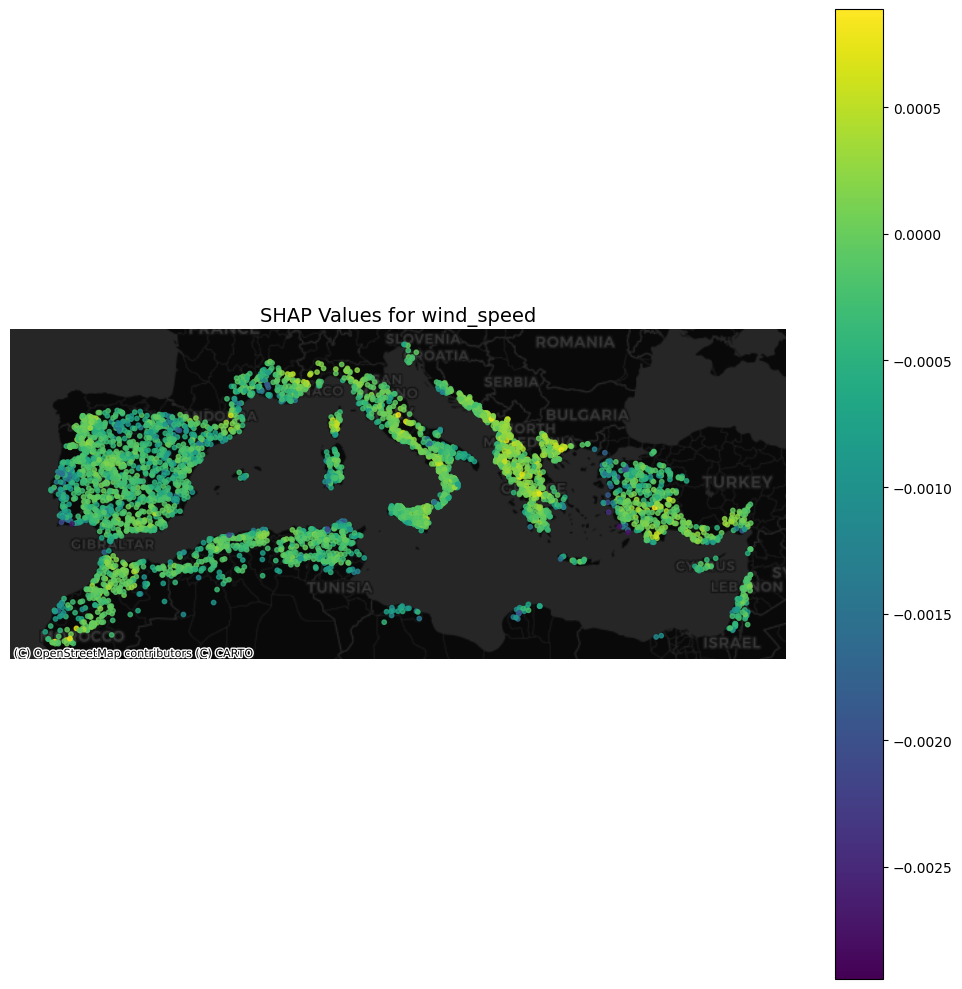

In [6]:
df = pd.read_csv(f"{path}/{file}")
df.rename(columns={"x": "lon", "y": "lat"}, inplace=True)
plot_shap_geopandas(df, shap_column="wind_speed", title="SHAP für wind_speed")